## Advanced Encryption Standard

### Wstęp

AES jest szyfrem symetrycznym blokowym uznanym przez NIST w 2001 roku. Przyjrzyjmy się po kolei co to oznacza:
- **symetryczny** oznacza, że jest jeden klucz, który jest tajny. W przypadku AES ma on 128 bitów, 192 lub 256 (zależne od wersji algorytmu). Słóży on do szyfrowania i deszyfrowania wiadomości, a więc musi być znany obu stronom komunikacji. Tu pojawia się pewien problem w koniunkcji słów "tajny" oraz "znany obu stronom" - bo to oznacza, że trzeba go sobie nawzajem jakoś przekazać. Do tego typu operacji słóży asymetryczna kryptografia, o której pomówimy kiedy indziej,
- **blokowy** oznacza, że klucz jest stałej długości, a wiadomość musi zostać podzielona na bloki również o stałej długości. Każdy z tych bloków jest szyfrowany zależnie lub niezależnie od poprzedniego. Jest to możliwe dzięki [trybom operacyjnym szyfrów blokowych](http://www.crypto-it.net/eng/theory/modes-of-block-ciphers.html). Skoro bloki mają być stałej długości, będziemy mieli tutaj także do czynienia z paddingiem, gdyż jest mało prawdopodobne, że rozmiar wiadomości będzie akurat wielokrotnością rozmiaru bloku.

Drugą odmianą szyfrów symetrycznych są szyfry strumieniowe, gdzie klucz posiada długość przynajmniej taką samą jak wiadomość, a proces szyfrowania przebiega "naraz", ale o tym innym razem.

Gdzie AES-a używamy? No między innymi w TLS i SSL. AES *na ten moment* jest uważany za odporny na ataki z wykorzystaniem komputera kwantowego. AES jest szybki (zarówno w implementacjach sfotware'owych jak i hardware'owych, włączając w to 8 bitowe długości słowa) - dlatego znalazł zastosowanie m.in. w szyfrowaniu dużych danych (z ang. *BigData*). Jest także używany do szyfrowania w chmurze na takich platformach jak Google Cloud, AWS czy OneDrive. AES jest do tej pory niezłamany. Innymi słowy: kawał dobrego szyfru.

**NOTE:** Do laboratorium dołączam dwa pomocnicze przy debugowaniu pdf-y. Znajdziesz w nich spodziewane wyniki dla przykładowych danych dla każdej funkcji opisanej w dalszej części. 

**Zadanie 1**

Zapoznaj się z trybami operacyjnymi szyfrów blokowych symetrycznych, które są podlinkowane powyżej. Zwróć uwagę na następujące aspekty:

1) Który tryb/które tryby są uznane za kryptograficznie niebezpieczne i dlaczego?

2) Jak wygląda propagacja błędu w poszczególnych trybach w procesie szyfrowania i deszyfrowania?

3) W których trybach można szyfrować równolegle, a w których można deszyfrować równolegle?

4) Czy do procesu deszyfrowania jest zawsze potrzebny algorytm deszyfrowania?

5) Który tryb jest najlepszy (wg Ciebie) i dlaczego?

### Stałe i podstawowa notacja

AES wszystkie operacje wykonuje na tablicy typu State, który teoretycznie jest macierzą bajtów 4x4:

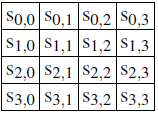

W praktyce jednak, 4 bajty to integer, dlatego State przechowuje się jako wektor czterech integerów. Zauważ, że z powyższego można wywnioskować iż rozmiar bloku w AES wynosi dokładnie 16B.

Załóżmy, że mamy wiadomość do zaszyfrowania zadaną jako:

M = 0xa1b1c1d1e1f1a2b2c2d2e2f2a3b3c3d3

Jest to wiadomość równa rozmiarowi bloku i takimi będziemy się zajmować - a to dlatego, że AES jako taki nie defniuje metody paddingu. Można użyć od prostych po skomplikowane, ale nie jest to już część tego algorytmu. Wiadmość M umieszczamy bajt po bajcie w tablicy State **kolumnami**. A więc po "włożeniu" M do State otrzymamy:

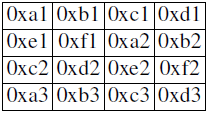

AES operuje w porządku *BigEndian*. W dalszej części laboratorium będziemy się odwoływać do State'a na dwa sposoby, przykłady poniżej:

1) S[0][0] - to będzie najbardziej znaczący bajt pierwszego integera w tablicy, równy 0xa1. Kolejnym by był S[0][1] równy 0xb1 itd.

2) S[0] - to będzie pierwszy z czterech integerów, czyli 0xa1b1c1d1. S[1] jest więc równy 0xe1f1a2b2 itd.


#### Stałe globalne

W naszych laboratoriach posłużymy się następującym zestawem stałych (używanych zarówno w procesie szyfrowania jak i deszyfrowania):

In [256]:
Nb = 4
Nk = 4
Nr = 10

Key = [0x00010203, 0x04050607, 0x08090a0b, 0x0c0d0e0f]

Rcon = [0x01000000, 0x02000000, 0x04000000, 0x08000000, 0x10000000, 0x20000000,
        0x40000000, 0x80000000, 0x1b000000, 0x36000000]

State = [0x00112233, 0x44556677, 0x8899aabb, 0xccddeeff]

Oznaczają one po kolei:

1) **Nb** - stała zawsze równa 4, ponieważ w tablicy State znajdują się 4 integery.

2) **Nk** - stałą zależna od wersji algorytmu (czyli długości klucza). My skupimy się na AES-128, dlatego Nk = 4. Byłoby ono równe 6 dla klucza 192 bity oraz 8 dla klucza 256 bitów.

3) **Nr** - liczba rund algorytmu, również zależna od długości klucza. Dla 128 bitów Nr = 10, dla 192 bitów Nr = 12, a gdy klucz ma 256 bitów Nr = 14. 

4) **key** - są to początkowe wartości klucza, które przekazujemy do algorytmu. W naszej wersji jest to dokładnie 16B, a więc wartość równa rozmiarowi bloku i State'a. Warto jednak zauważyć, że **key** będziemy traktowali jako listę, bo bedziemy do niego dodawać wartości. AES zawiera specjalny algorytm generowania kolejnych wartości klucza tak, aby w każdej rundzie używać kolejnych czterech różnych wartości. W tym algorytmie z kolei wykorzytywany jest wektor stałych **Rcon**. Więcej o tym w dalszej części laboratorium.

5) **state** - to będzie nasz State w którym już umieściłem wiadomość do zaszyfrowania. 

#### Stałe wykorzystywane w procesie szyfrowania

Są to:

In [257]:
Sbox = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
)

mixingVars = [0x02030101, 0x01020301, 0x01010203, 0x03010102]

Używamy ich w poszczególnych funkcjach AES'a. Wyjaśnione w dalszej części laboratorium.

#### Stałe wykorzystywane w procesie deszyfrowania

Są to:

In [258]:
InvSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

invMixingVars = [0x0e0b0d09, 0x090e0b0d, 0x0d090e0b, 0x0b0d090e]

Podobnie jak w poprzednim przypadku, wyjaśnione w dalszej części laboratorium.

### Funkcje wykorzystywane w AES

Będziemy potrzebowali funkcji pomocniczych zwanych *rotWordLeft* i *rotWordRight*, które wykonują odpowiednio lewą i prawą rotację integera o *n* bitów.

Będziemy także potrzebowali funkcji pomocniczej *transpo*, która dokonuje transpozycji State'a. Przypominam: transpozycja Oznacza, że wiersze stają się kolumnami (lub kolumny wierszami). Uwaga, po wykonaniu funkcji *transpo* State powinien być cały czas wektorem integerów tylko o odpowiednio zmienionych bajtach.

**Zadanie 2**

Uzupełnij kod poniższych metod. Dwie pierwsze mają rotować integera *tmp* o *n* bitów i zwracać zrotowaną wartość. Ostatnia ma dokonywać transpozycji State'a.



In [259]:
def rotWordLeft(tmp, n):
    binary = format(tmp, '32b').replace(' ', '0')
    res = binary[n:] + binary[:n]
    return int(res, 2)

def rotWordRight(tmp, n):
    binary = format(tmp, '32b').replace(' ', '0')
    res = binary[-n:] + binary[:-n]
    return int(res, 2)

def transpo(state):
    M = [val.to_bytes(Nb) for val in state]
    new_state = []
    for i in range(Nb):
        v = 0
        for j in range(Nb):
            v *= 256
            v += M[j][i]
        new_state.append(v)
    return new_state

Poniżej przedstawiam wszystkie funkcje, które będą nam potrzebne do napisania finalnego algorytmu szyfrowania i deszyfrowania. 

**NOTE:** W algorytmach rozpisanych w formie kroków pojawią się pętlę, które wykonujemy od-do *włączając w to ostatni element*. 

#### Funkcje 1: subWord'y

Funkcje te zastępują poszczególne wartości bajtów ze State'a tymi z tablicy Sbox (lub invSbox). Dany bajt jest dzielony na dwie wartości po 4 bity, i te bardziej znaczące odpowiadają wierszowi w Sbox, a te 4 mniej znaczące - kolumnie.

Przykład: niech State[0][0] = 0xa1. Nowa wartość będzie tą odpowiadającą wartości w dziesiątym wierszu i pierwszej kolumnie tablicy Sbox, czyli 0x32.

Potrzebujemy razem cztery funkcje:
- **subWords()**:

1) Dla i = 0,...,3 wykonuj krok 2:

2) State[i] = subWord(State[i]).

- **subWord(tmp)**:

1) Dla i = 0,...,3 wykonuj krok 2:

2) tmp[i] = Sbox[tmp[i] >> 4][tmp[i] & 0x0F]

3) zwróć tmp

- **invSubWords()**:

1) Dla i = 0,...,3 wykonuj krok 2:

2) State[i] = invSubWord(State[i]).

- **invSubWord(tmp)**:

1) Dla i = 0,...,3 wykonuj krok 2:

2) tmp[i] = invSbox[tmp[i] >> 4][tmp[i] & 0x0F]

3) zwróć tmp

Metody bez przedsrostka "inv" są używane w operacjach szyfrowania oraz rozszerzania klucza, a te z przedrostkiem "inv" w operacji deszyfrowania. Metoda *subWords* iteruje po integerach ze State'a, a metoda *subWord(tmp)* iteruje po bajtach itegera otrzymanego jako parametr i zwraca nowego integera. Metody "inv" analogicznie.



**Zadanie 3** 

Zaprogramuj wszystkie cztery powyższe metody.

In [260]:
def int_to_array(val):
    return val.to_bytes(4)

def array_to_int(arr):
    val = 0
    for v in arr:
        val *= 256
        val += v
    return val

In [261]:
def subWords(state):
    for i in range(Nb):
        state[i] = subWord(state[i])
    return state

def subWord(tmp):
    arr = int_to_array(tmp)
    res = [None] * Nb
    for i in range(Nb):
        res[i] = Sbox[(arr[i] >> 4) * 16 + (arr[i] & 0x0F)]
    return array_to_int(res)

def invSubWords(state):
    for i in range(Nb):
        state[i] = invSubWord(state[i])
    return state

def invSubWord(tmp):
    arr = int_to_array(tmp)
    res = [None] * Nb
    for i in range(Nb):
        res[i] = InvSbox[(arr[i] >> 4) * 16 + (arr[i] & 0x0F)]
    return array_to_int(res)

#### Funkcja 2: expandKey()

Jako parametr przyjmuje listę integerów *key* zadaną na początku algorytmu, a zwraca rozszerzoną listę integerów *key* zawierającą $(Nr + 1) * Nb$ integerów. Dlaczego tak? Zauważ, że mamy 10 rund i dla każdej potrzebujemy 4 różnych wartości klucza, to daje 40 integerów. Dodatkowo algorytm zakłada, nazwijmy to, rundę zerową, gdzie wykorzystuje te cztery wartości klucza zadane na początku, a więc końcowy rozmiar *key* to 44 integery (w naszym przypadku).

Algorytm *expandKey()*:

1) Dla i = Nk ... (Nr + 1) * Nb - 1 wykonuj kroki 2 - 7.

2) Wykonaj: tmp = key[i - 1].

3) Jeżeli i mod Nk = 0 wykonaj krok 4, w przeciwnym razie idź do kroku 5.

4) tmp = rotWordLeft(subWord(tmp), 8) $⊕$ Rcon[⌊$\frac{i}{Nk}⌋ -1 $].

5) Jeżeli Nk > 6 oraz i mod Nk = 4 wykonaj krok 6, w przeciwnym razie wykonaj krok 7.

6) tmp = subWord(tmp).

7) key.append(key[i - Nk] $⊕$ tmp).

**Zadanie 4**

Zaimplementuj powyższy algorytm.

In [262]:
def expandKey():
    key = Key.copy()
    for i in range(Nk, (Nr + 1) * Nb):
        tmp = key[i-1]
        if i % Nk == 0:
            tmp = rotWordLeft(subWord(tmp), 8) ^ Rcon[i // Nk - 1]
        if Nk > 6 and i % Nk == 4:
            tmp = subWord(tmp)
        key.append(key[i - Nk] ^ tmp)
    return key

#### Funkcja 3 - shiftRow'y

Są stosunkowo proste, polegają na rotacji bajtów w integerach State'a. Rotacja zależy od indeksu integera w State'cie.

Algorytm *shiftRows()*:

1) Wywołaj transpo().

2) Dla i = 0,...,3 wykonuj krok 3.

3) State[i] = rotWordLeft(State[i], i * 8).

4) Wywołaj transpo().

Ten algorytm jest używany przy szyfrowaniu. Przy deszrowaniu używamy algorytmu *invShiftRows*, który jest identyczny jak ten powyżej z tą różnicą, że zamiast *rotWordLeft* wykorzystujemy *rotWordRight*.

**Zadanie 5**

Zaimplementuj *shiftRows* i *invShiftRows*.

In [263]:
def shiftRows(state):
    state = transpo(state)
    for i in range(Nb):
        state[i] = rotWordLeft(state[i], i * 8)
    return transpo(state)
    
def invShiftRows(state):
    state = transpo(state)
    for i in range(Nb):
        state[i] = rotWordRight(state[i], i * 8)
    return transpo(state)

#### Funkcja 4 - addRoundKey

Również mało skomplikowana. Wykonuje operację XOR pomiędzy integerami State'a a odpowiednimi integerami klucza. Jako parametr przyjmuje *roundKey*, czyli czteroelementową tablicę integerów, na którą składają się odpowiednie integery zaczerpnięte z listy *key*.

Algorytm funkcji *addRoundKey(roundKey)*:

1) Dla i = 0,...,3 wykonuj krok 2.

2) State[i] = State[i] $⊕$ roundKey[i].

Ta funkcja jest używana zarówno przy szyfrowaniu jak i deszyfrowaniu.

**Zadanie 6**

Zaimplementuj *addRoundKey*.

In [264]:
def addRoundKey(roundKey, state):
    for i in range(Nb):
        state[i] = state[i] ^ roundKey[i]
    return state

#### Funkcja 5 - mixColumn'y

Najbardziej skomplikowana, choć pozornie niewinna. W tej funkcji State rozumiemy z powrotem jako dwuwymiarową tablicę bajtów. Cała operacja do wykonania to mnożenie macierzy: *mixingVars* (w przydaku deszyfrowania *invMixingVars*) z transponowanym Statem, a poźniej transpozycja wyniku. Dla operacji szyfrowania można to zapisać jako:

$State = (mixingVars \times State^T)^T$

Algorytmu mnożenia macierzy nie będę rozpisywał, w razie potrzeby uzupełnił tą wiedzę samodzielnie. Jak widzisz będziemy tu mnożyli bajty i dodwali. Załóżmy, że mamy więc dwa bajty *a* i *b*. Operację $a + b$ wykonujemy jako $a \oplus b$. Problem jest jednak z działaniem $a * b$. W tej funkcji wszystkie operacje wykonujemy w ciele Galoisa oznaczonym jako $GF(2^8)$. Tak naprawdę to stałe zapisane w *mixingVars* i *invMixingVars* stanowią współczynniki specjalnych wielomianów, które pozwalają nam wykonywać operację mnożenia modulo. Nie musimy rozważać całej matematyki za tym idącej, ale musimy wiedzieć, że mnożenie $a * b$ musimy rozpisać jako odpowiednią kombinację mnożeń $a * 0x02$ oraz $a * 0x01$.

Dla mnożenia razy 0x01 jest łatwo, rozumiemy je tak jak w naszej algebrze, czyli $a * 0x01 = a$. Dla mnożenia razy 0x02 mamy specjalny algorytm. Nasz bajt $a$ można zapisać jako ciąg binarny: $a = [b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0]$, gdzie $b^7$ to bit najbardziej znaczący. 

Algorytm wyliczenia działania $a * 0x02$ jest następujący:

1) Jeżeli $b^7 = 1$ to: a * 0x02 = (a << 1) $⊕$ 0x1b.

2) W przeciwnym razie: a * 0x02 = a << 1.

Spójrzmy więc na przykład: niech $a = 0xaa$, a $b = 0x09$. Działanie $a * b$ można rozpisać jako: $0xaa * 0x09 = 0xaa * (0x02 * 0x02 * 0x02 + 0x01) = 0xaa * 0x02 * 0x02 * 0x02 + 0xaa = 0x4f * 0x02 * 0x02 + 0xaa = 0x9e * 0x02 + 0xaa = 0x27 + 0xaa = 0x8d$.

**Zadanie 7**

Zaimplementuj funkcje *mixColumns* oraz *invMixColumns*.

**NOTE:** w tym zadaniu wskazane jest utworzyć sobie funkcje pomocnicze, np. do mnożenia macierzy, mnożenia bajtów itp.

In [265]:
# ciało Galoisa
def gadd(a, b):
    return a ^ b

def mul2(a):
    if a >= 128:
        a = (a << 1) ^ 0x1b
    else:
        a = a << 1
    return a % 256

def gmul(a, b):
    if b == 0:
        return 0
    s = format(b, '8b').replace(' ', '0')
    arr = []
    for i, t in enumerate(s):
        if t == '0':
            continue
        tmp = a
        for _ in range(7-i):
            tmp = mul2(tmp)
        arr.append(tmp)
    res = arr[0]
    for i in range(1, len(arr)):
        res = gadd(res, arr[i])
    return res

In [266]:
def matrix_gmul(A, B):
    A = [int_to_array(val) for val in A]
    B = [int_to_array(val) for val in B]
    res = [[None] * Nb for _ in range(Nb)]
    for i in range(Nb):
        for j in range(Nb):
            val = 0
            for k in range(Nb):
                a = A[i][k]
                b = B[k][j]
                val = gadd(val, gmul(a, b))
            res[i][j] = val
    return [array_to_int(arr) for arr in res]

def mixColumns(state):
    return transpo(matrix_gmul(mixingVars, transpo(state)))
    
def invMixColumns(state):
    return transpo(matrix_gmul(invMixingVars, transpo(state)))


### Algorytm szyfrowania AES

1) expandKey().

2) State = M (czyli zakoduj wiadomość do State'a - **ten krok mamy już wykonany**, wiadomość jest już w State'cie).

3) addRoundKey(key[0,...,Nb - 1]).

4) Dla i = 1,...,Nr - 1 wykonuj kroki 5-8.

5) subWords().

6) shiftRows().

7) mixColumns().

8) addRoundKey(key[i * Nb,...,(i + 1) * Nb - 1]).

9) Po wyjściu z pętli wykonaj ponowanie kroki 5 i 6.

10) addRoundKey(key[Nr * Nb,...,(Nr + 1) * Nb - 1]).

Nasz State zawiera teraz kryptogram.

**Zadanie 8**

Zaimpmenetuj algorytm szyfrowania AES.

In [267]:
def encrypt(state):
    key = expandKey()
    state = addRoundKey(key, state)
    for i in range(1, Nr):
        state = subWords(state)
        state = shiftRows(state)
        state = mixColumns(state)
        state = addRoundKey(key[i*Nb:], state)
    state = subWords(state)
    state = shiftRows(state)
    state = addRoundKey(key[Nr*Nb:], state)
    return state

In [268]:
encrypted = encrypt(State.copy())
print([hex(word) for word in encrypted])

['0x69c4e0d8', '0x6a7b0430', '0xd8cdb780', '0x70b4c55a']


### Algorytm deszyfrowania AES

1) expandKey() - (należy pominąć, zrobiliśmy to już przy szyfrowaniu. W praktyce jednak najczęściej AES'a używają dwie różne strony komunikacji).

2) addRoundKey(key[Nr * Nb,...,(Nr + 1) * Nb - 1]).

3) Dla i = Nr - 1,...,1 wykonuj kroki 4-7.

4) invSubWords().

5) invShiftRows().

6) addRoundKey(key[i*Nb,...,(i + 1) * Nb - 1]).

7) invMixColumns().

8) Po wyjściu z pętli wykonaj kroki 4 i 5 jeszcze raz.

9) addRoundKey(key[0,...,Nb - 1]).

Teraz nasz State powinien przechowywać zdeszyfrowaną wiadomość.

**Zadanie 9**

Zaimplementuj algorytm deszyfrowania AES.

In [269]:
def decrypt(state):
    key = expandKey()
    state = addRoundKey(key[Nr*Nb:], state)
    for i in range(Nr-1, 0, -1):
        state = invSubWords(state)
        state = invShiftRows(state)
        state = addRoundKey(key[i*Nb:], state)
        state = invMixColumns(state)
    state = invSubWords(state)
    state = invShiftRows(state)
    state = addRoundKey(key, state)
    return state

In [270]:
decrypted = decrypt(encrypted)
print([hex(word) for word in decrypted])
assert decrypted == State
print("Success!")

['0x112233', '0x44556677', '0x8899aabb', '0xccddeeff']
Success!
